## Building a Simple Unit Test for the Flogo Inference Activity

<p>The goal of this notebook is to build a simple CNN model to be used as</p>
<ul>
<li>A small tensorflow model to use as unit test for the Flogo Inference Activity</li>
<li>A demonstration of building and exporting a model into a format that can be used in Flogo's inference activity.</li>
</ul>
<p>Therefore the "problem" we are going to solve with CNN is this:</p>
<blockquote><p>Given an array of size "size" containing a gaussian determine whether the maximum value is in the lower half of the array (value=0) or the upper half (value=1).</p></blockquote>

<p>Since this is a sample problem I will generate my own test/train data sets.</p>

### Notebook setup
<ul>
<li>Modules used</li>
<li>Meta-parameters used within notebook.</li>
<li>Basic functions defined to expidite coding</li>
</ul>

#### Import Required modules - Numpy , Tensorflow, and Matplotlib/Seaborn with a few default packages as well.

In [1]:
%matplotlib inline  
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn
import random
import math
import time

#### Meta Parameters

In [2]:
size=10               # Size of the Array to contain the gaussians - MUST BE EVEN

lr=5e-4               #Learning rate of the CNN 
numfilters=15          #Number of convolution windows/fliters to use 

batchsize=50          #Training Batch size
eval_size=500         #Evaluation set size

pstep=25             #Number of training sets at which to print out loss, accuracy, etc. of training step
estep=100            #Number of training sets at which to test and print the reults of the Evaluation set
train_steps=2001     #Total number of training sets - Useful to have the one at the end to make the last set 
                     #   print out


#### Defining useful functions
<ul>
    <li> "bell_fn"- A function that given x,x0, alpha and beta gives the resulting gaussian of: beta*exp((x-x0)^2/alpha)</li>
    <li> "data_point" - Given the size of the array needed generate an input and the corresponding training label</li>
    <li> "create_batch" - Given batch size create a batch of inputs/outputs that can be used for training or testing</li>
</ul>

In [3]:
def bell_fn(x,x0,alpha,beta): #beta*exp((x-x0)^2/alpha)
    xxo=x-x0
    return beta*math.exp(-xxo*xxo/alpha)

In [4]:
def data_point(size=10,alpha=5,beta=10):
    #adding some noise to the default alpha and beta
    if alpha==5 and beta==10:
        alpha=alpha+(random.random()*2-1)
        beta=beta+(random.random()*2-1)
    out = np.zeros(size)
    loc=random.random()*size
    out=np.array([bell_fn(i,loc,alpha,beta) for i in range(size)])
    #print(loc)
    return out,0 if np.argmax(out) <size//2 else 1

In [5]:
def create_batch(batchsize):
    x=[]
    y=[]
    for i in range(batchsize):
        xi,yi=data_point(size)
        xi=[[[a]] for a in xi]
        x.append(xi)
        y.append(yi)
    x=np.array(x)
    y=np.array(y)
    return x,y

### Building the Graph for the model
<p>As mentioned in the introduction, we are going to build a CNN to operate on the gaussian array of size "size".  We are going to use a fairly basic convolution/pooling/fully connected layered setup.  Because of the simpleness of the problem statement (and to make a smale model for the unit test) we will only use a single conv/pool/fc layer.</p>
<p>It is worth noting that the conv2d tensorflow function is used with the second dimension and channel ranks set to 1 instead of using tf.layers.conv1d because conv1d has a bug that has been fixed in tensorflow 1.11, but currently conda only has tensoflow at 1.10.</p>

In [6]:
#Defining placeholders (Nodes to accept input) for the input gaussian array (X) and the training labels (Y).
X = tf.placeholder(tf.float32,[None,size,1,1],name='X')  #[batchsize,size,1]
Y = tf.placeholder(tf.int32,[None],name='Y')     #[batchsize]

#My conv/max pooling/ fully connected layers.  Notice my Pooling is choosen to divide the data into a top and 
#   bottom half to make the identification of whether the max is in the top or bottom half easier.
conv1 = tf.layers.conv2d(inputs=X,filters=numfilters,kernel_size=[2,1],strides=1,padding='same',activation=tf.nn.relu,name='conv')
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=size//2,strides=size//2,padding='same')
pool1 = tf.reshape(pool1,[-1,numfilters*2],name='pool')
logits = tf.layers.dense(inputs = pool1, units=2, activation=tf.nn.tanh,name='fcon1')

#Using Softmax to get probabilities from the logits
probabilities=tf.nn.softmax(logits,name='softmax')

#Getting the loss, prediction, and accuracy
loss = tf.losses.sparse_softmax_cross_entropy(labels=Y,logits=logits)#,reduction=tf.losses.Reduction.NONE)
pred = tf.argmax(input=probabilities, axis=1,name="pred")
accuracy = tf.metrics.accuracy(labels=Y, predictions=pred)

#Defining the optimization step
train_step=tf.train.AdamOptimizer(lr).minimize(loss)

### Creating and initializing the Tensorflow session
<p>Remember with TF you need to define the graph (above) and then create a session to "run" the graph.  Here we create the session and initialize the global and local variables in the graph.  Then because the trainable variables are pretty small here we take a look at the variables in the model.  Yup should be small enough for a unit test to be stored on github.</p>

In [7]:
sess=tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

In [8]:
#looking at the various trainable variables
variables_names = [v.name for v in tf.trainable_variables()]
values = sess.run(variables_names)
for k, v in zip(variables_names, values):
    print ("Variable: ", k)
    print ("Shape: ", v.shape)
    print (v)

Variable:  conv/kernel:0
Shape:  (2, 1, 1, 15)
[[[[ 0.3124455   0.03911668 -0.22816731  0.18111172 -0.32070804
     0.06484324  0.15507439 -0.2589414   0.07914296  0.23594603
    -0.1644884   0.2390627  -0.4072155  -0.07656926 -0.29182953]]]


 [[[-0.3685084  -0.18050045  0.0896301   0.14999911  0.1548188
     0.33474723  0.23378822  0.38202962  0.01755071  0.30117908
     0.37522277  0.30340967 -0.34644172  0.2127724  -0.26057598]]]]
Variable:  conv/bias:0
Shape:  (15,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Variable:  fcon1/kernel:0
Shape:  (30, 2)
[[ 0.2446551   0.23777756]
 [ 0.4295577   0.2667931 ]
 [-0.42782715  0.05270955]
 [ 0.29815903 -0.11822918]
 [ 0.00050452 -0.42741573]
 [ 0.4272459   0.22994438]
 [-0.3497372  -0.25100434]
 [ 0.12461451  0.07820824]
 [-0.36327308 -0.11236423]
 [ 0.26886454 -0.2924248 ]
 [-0.28388584 -0.2989422 ]
 [-0.05223545 -0.2276599 ]
 [-0.18197387  0.40160194]
 [ 0.20518109  0.32966128]
 [ 0.1974729   0.3220531 ]
 [ 0.16404316 -0.3330704 ]
 [ 

### Training the model
<p>Here we create a large batch for evaluation purposes then we train the model printing out the training and evaluation results periodically.  It is worth noting that for the default metaparamters defined above sometimes the model gets stuck in a local loss minimum where either the predictions are always 1 or 0 or the predictions are actually the opposite of the expected result.  Starting from scratch and/or changing the training rate can fix this.  Also, the number of steps to get 100% accuracy can vary wildly for the same learning rate.</p>
<p> All of this can be improved by increasing the number of filters.  This speeds up both training and reduces chances of getting stuck in a local mazimum, but increases the size of the model, which should be as small as possible for the unit test.  Based upon testing the resulting size of the model it turns out numfilters = 15 minimize the size and maximizes stability.</p>

In [9]:
step=0                #initialling my step count so I can use my training block multiple times without 
                      #    resetting the count.
trainres=[]           # Saving results along the way for plotting later
evelres=[]            # Saving results along the way for plotting later

In [10]:
ex,ey=create_batch(eval_size)

In [11]:
if step:
    train_steps+=step

for step in range(step,train_steps):
    
    xb,yb=create_batch(batchsize)

    feed_dict={X:xb,Y:yb}
    _,(ac,ac_op),lo,pr=sess.run([train_step,accuracy,loss,pred],feed_dict=feed_dict)
    
    if step%pstep==0:
        ac=1-sum(np.fabs(pr-yb))/len(yb)
        s="Training step {:5d}: loss = {:7.5f} accuracy = {:7.5f}".format(step,lo,ac)
        print(s)
        trainres.append([step,lo,ac])

    if step%estep==0:
        feed_dict={X:ex,Y:ey}#,lr:1e-3}
        (ac,ac_op),lo,pr2=sess.run([accuracy,loss,pred],feed_dict=feed_dict)
        ac2=1-sum(np.fabs(pr2-ey))/len(ey)
        print("EVAL {:5d}: loss = {:7.5f} accuracy = {:7.5f}".format(step,lo,ac2))
        evelres.append([step,lo,ac2])
 

Training step     0: loss = 0.58613 accuracy = 0.54000
EVAL     0: loss = 0.70886 accuracy = 0.44800
Training step    25: loss = 0.43587 accuracy = 0.84000
Training step    50: loss = 0.38358 accuracy = 0.88000
Training step    75: loss = 0.23036 accuracy = 0.98000
Training step   100: loss = 0.20598 accuracy = 1.00000
EVAL   100: loss = 0.21641 accuracy = 0.99000
Training step   125: loss = 0.21126 accuracy = 0.98000
Training step   150: loss = 0.21569 accuracy = 1.00000
Training step   175: loss = 0.23280 accuracy = 0.96000
Training step   200: loss = 0.17887 accuracy = 1.00000
EVAL   200: loss = 0.18435 accuracy = 0.99200
Training step   225: loss = 0.20992 accuracy = 1.00000
Training step   250: loss = 0.17607 accuracy = 1.00000
Training step   275: loss = 0.17850 accuracy = 1.00000
Training step   300: loss = 0.21766 accuracy = 0.92000
EVAL   300: loss = 0.17304 accuracy = 0.99600
Training step   325: loss = 0.15414 accuracy = 1.00000
Training step   350: loss = 0.17313 accuracy =

In [12]:
print("Predicted Output of Evaluation set:")
print(pr2)
print("Evalutation Set Labels:")
print(ey)

Predicted Output of Evaluation set:
[1 1 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 0 0 0 1 1 1 0 1 0 0 1 1 1 1 0 1 0
 0 1 1 1 0 1 1 0 0 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 0 1 0 1 1 0 0
 1 0 1 0 1 1 1 0 1 1 0 0 1 0 1 0 0 1 0 0 1 1 1 1 0 0 1 0 1 0 0 1 0 1 1 1 1
 0 1 0 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 0
 1 1 1 1 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 0 0 1 0 0 1 1 1 0 1 1 0 0 1
 1 0 0 1 0 1 1 1 1 0 0 1 0 0 0 1 1 1 1 0 0 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 0
 1 1 0 1 1 1 0 0 0 1 0 0 0 0 1 1 0 0 0 1 1 1 1 1 0 0 1 0 0 1 1 1 0 1 0 0 0
 0 1 0 0 0 1 1 1 1 1 1 0 0 1 1 0 0 0 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1
 1 1 0 1 1 0 0 0 0 1 1 0 1 1 0 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 0 1 1 0 1 1 0 0 1 0 0 0 1 0 1 0 1 0 1 1 0 0 1 1 1 1 1 0 1 1 0 0
 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 0 0 0 1 1 1 0 0 0 0 1 1 0 1 1 0 0 1 0 1 0
 0 0 1 1 0 0 0 0 1 1 0 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 0 1 1 0
 0 0 1 1 0 1 1 0 0 1 0 1 1 0 1 1 1 0 0 0 1 0 0 1 1 1 0 0 0 1 1 1

### Printing Loss and Accuracy for training and Evaluation sets

In [13]:
tr=np.array(trainres)
ev=np.array(evelres)

<p><b>Note</b>: that training is done with new data (i.e. not previously seen by the model) at every step without epocs.  This means the training and evaluation data are comparable.</p>

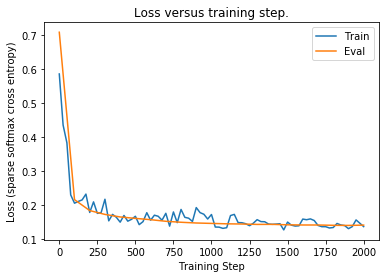

In [14]:
plt.title('Loss versus training step.')
plt.xlabel('Training Step')
plt.ylabel('Loss (sparse softmax cross entropy)')
plt.plot(tr[:,0],tr[:,1],label='Train')
plt.plot(ev[:,0],ev[:,1],label='Eval')
plt.legend()
plt.show()

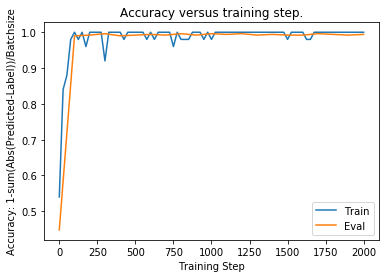

In [15]:
plt.title('Accuracy versus training step.')
plt.xlabel('Training Step')
plt.ylabel('Accuracy: 1-sum(Abs(Predicted-Label))/Batchsize')
plt.plot(tr[:,0],tr[:,2],label='Train')
plt.plot(ev[:,0],ev[:,2],label='Eval')
plt.legend()
plt.show()

### Exporting/Saving the model to file
<p>The standard output format of TensorFlow is the SavedModel format containing a protobuf (*.pb) file and a variables directory containing the values of the trainable variables.  Flogo reads this in assuming that the protobuf file contains the appropriate metadata.  Below we use the simple_save function to define the metadata (containing inputs and outputs) and write to file.  We also use the write_graph function to export the protobuf into readable text.  However this *pbtxt file does not contain the metadata.</p>

In [16]:
t="%d"%int(time.time()*100)
print(t)
path="./SimpleCNNModel/{:s}/".format(t)
inputs={"X":X}
outputs={"pred":pred}
tf.saved_model.simple_save(sess, path,inputs=inputs,outputs=outputs)
tf.train.write_graph(sess.graph, './SimpleCNNTextModel/{:s}/'.format(t), 'train.pbtxt',as_text=True)

154031266409
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./SimpleCNNModel/154031266409/saved_model.pb


'./SimpleCNNTextModel/154031266409/train.pbtxt'